# Preparing and cleaning the dataset

In [ ]:
import requests
from bs4 import BeautifulSoup
import json

In [ ]:

result=[]
errors=[]
Total_errors=[]
def web_scrape1(url, i, ind):
# Send a GET request to the webpage
  response = requests.get(url)

# Check if the request was successful
  if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract the title
    title = soup.find('h1').text.strip() if soup.find('h1') else "Title not found"

    # Extract the author
    author_div = soup.find('div', attrs={"data-byline-author": True})
    author = author_div.text.strip() if author_div else "Author not found"

    # Extract the poem text
    main_poem = soup.find('div', id='block-stanza-content')
    poem_lines = main_poem.find_all('span', class_='long-line') or main_poem.find_all('pre') or main_poem.find_all('p')
    if poem_lines:
      poem_text = "\n".join([line.text.strip() for line in poem_lines])

    else:
      print("Poem not found")
      err_info = {
          "Page": i,
          "URL": url
      }
      errors.append(err_info)
      Total_errors.append(ind)



    # Structure the poem data
    poem_data = {

        "poem": poem_text
    }

    # Print the poem details to the console

    #print(poem_data["poem"])
    #result.append({"Poem": poem_data["poem"]})
    return poem_data

  else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")



def web_scrape2(url, i):

  res= requests.get(url) # Here, we sent an http request for this website
  if res.status_code==200:
    # Checking if the http request has been completed
    soup= BeautifulSoup(res.content, 'html.parser') # parsing the content of the page
    poems=soup.select('tr') # Selecting all 'tr' elements with select method

    if not poems:
            print("No tr found with the specified class.")
            return
    for ind, poem in enumerate(poems):
      title_cell = poem.find('td', class_="views-field-title") # Finding the title element inside a particular poem, by specifying a class particular to poem titles
      #Finding the poet name element inside a particular poem, by specifying a class particular to poet names
      poet_cell = poem.find('td', class_="views-field-field-author")
      #Finding the date element inside a particular poem, by specifying a class particular to dates
      date_cell = poem.find('td', class_="views-field-field-date-published")
      if title_cell and poet_cell and date_cell:

                title = title_cell.find('a').text.strip() #Finding title text inside 'a', and stripping off any whitespaces
                poem_url = "https://poets.org" + title_cell.select('a')[0].get('href') # Adding link to a particular poem, stored in href attribute of its 'a' tag, by get method
                poet_link = poet_cell.find('a')
                poet = poet_link.text.strip() if poet_link else "N/A" # checking if poet's name is given or not
                time_tag = date_cell.find('time')
                date = time_tag.text.strip() if time_tag else "N/A"
                print(f"\033[1mTitle\033[0m: {title}, Poem URL: {poem_url}, Poet: {poet}, Date: {date}")

                poem_data = {
                              "Title": title,
                              "Author": poet,
                              "Date": date,
                              "Poem": web_scrape1(poem_url, i, ind)
                            }
                result.append([poem_data]) # Adding the poem data in result list
                #web_scrape1(poem_url, i, ind)

  else:
        print(f"Failed to retrieve page: {res.status_code}")

# Enter the range between 1 and 789
for i in range(101):
  print(f"Page : {i}")
  web_scrape2("https://poets.org/poems? "+f"page={i}", i)

print(str(len(Total_errors)) + " errors occured")
print(errors)

Page : 0
Title: A Line-storm Song, Poem URL: https://poets.org/poem/line-storm-song, Poet: Robert Frost, Date: 1913


KeyboardInterrupt: 

In [ ]:
from google.colab import files

with open("merged_file.json", "w") as outfile:
    json.dump(result, outfile)
files.download("mg.json")

NameError: name 'result' is not defined

In [ ]:
import json
import re
# Load raw data from the JSON file
with open("/content/dataset.json", "r") as f:
    data = json.load(f)
print(type(data))
print(data[:5])

<class 'list'>
[[{'Title': 'A Line-storm Song', 'Author': 'Robert Frost', 'Date': '1913', 'Poem': {'poem': 'The line-storm clouds fly tattered and swift,\nThe road is forlorn all day,\nWhere a myriad snowy quartz stones lift,\nAnd the hoof-prints vanish away.\nThe roadside flowers, too wet for the bee,\nExpend their bloom in vain.\nCome over the hills and far with me,\nAnd be my love in the rain.\nThe birds have less to say for themselves\nIn the wood-world’s torn despair\nThan now these numberless years the elves,\nAlthough they are no less there:\nAll song of the woods is crushed like some\nWild, easily shattered rose.\nCome, be my love in the wet woods; come,\nWhere the boughs rain when it blows.\nThere is the gale to urge behind\nAnd bruit our singing down,\nAnd the shallow waters aflutter with wind\nFrom which to gather your gown.\nWhat matter if we go clear to the west,\nAnd come not through dry-shod?\nFor wilding brooch shall wet your breast\nThe rain-fresh goldenrod.\nOh, never

# Cleaning the dataset


In [ ]:

# Process each poem in the nested structure
cleansed_data_list = []

for entry in data:
    # Each entry is a list containing a dictionary
    if isinstance(entry, list) and len(entry) > 0 and isinstance(entry[0], dict):
        poem_data = entry[0]  # Access the dictionary inside the list

        # Extract fields safely
        title = poem_data.get("Title", "Untitled")
        author = poem_data.get("Author", "Unknown")
        poem_text = poem_data.get("Poem", {}).get("poem", "")

        # Cleansing process for the poem text
        cleaned_poem = re.sub(r"[^\w\s,.'-]", "", poem_text)  # Removes special characters except basic ones
        cleaned_poem = re.sub(r"\s+", " ", cleaned_poem)  # Replaces multiple spaces with a single space
        cleaned_poem = cleaned_poem.replace(" .", ".").replace(" ,", ",")  # Fix misplaced spaces before punctuation

        # Preserving line breaks
        lines = [line.strip() for line in cleaned_poem.split("\n") if line.strip()]  # Remove empty lines
        cleaned_poem = "\n".join(lines)

        # Append the cleansed data
        cleansed_data_list.append({
            "title": title,
            "author": author,
            "poem": cleaned_poem,
            "date": poem_data.get("Date", "Unknown")
        })

# Print the cleansed poems
for cleansed_data in cleansed_data_list:
    print("Cleansed Poem:\n")
    print(f"Title: {cleansed_data['title']}")
    print(f"Author: {cleansed_data['author']}")
    print(f"Date: {cleansed_data['date']}")

    print(cleansed_data['poem'])

Cleansed Poem:

Title: A Line-storm Song
Author: Robert Frost
Date: 1913
The line-storm clouds fly tattered and swift, The road is forlorn all day, Where a myriad snowy quartz stones lift, And the hoof-prints vanish away. The roadside flowers, too wet for the bee, Expend their bloom in vain. Come over the hills and far with me, And be my love in the rain. The birds have less to say for themselves In the wood-worlds torn despair Than now these numberless years the elves, Although they are no less there All song of the woods is crushed like some Wild, easily shattered rose. Come, be my love in the wet woods come, Where the boughs rain when it blows. There is the gale to urge behind And bruit our singing down, And the shallow waters aflutter with wind From which to gather your gown. What matter if we go clear to the west, And come not through dry-shod For wilding brooch shall wet your breast The rain-fresh goldenrod. Oh, never this whelming east wind swells But it seems like the seas retu

In [ ]:
with open("cleansed1.txt", "w") as f:
    json.dump(cleansed_data_list, f)

In [ ]:
from google.colab import files

files.download('cleansed1.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# To merge JSON files if needed


In [ ]:
import json

# Load the first JSON file
with open("/content/dataset (2).json", "r", encoding="utf-8") as f1:
    data1 = json.load(f1)

# Load the second JSON file
with open("/content/dataset.json", "r", encoding="utf-8") as f2:
    data2 = json.load(f2)

# Merge the files based on their structure
if isinstance(data1, list) and isinstance(data2, list):
    # Combine the two lists
    merged_data = data1 + data2
elif isinstance(data1, dict) and isinstance(data2, dict):
    # Merge two dictionaries
    merged_data = {**data1, **data2}
else:
    raise ValueError("The JSON files have incompatible structures.")

# Save the merged data to a new file
with open("merged_file.json", "w", encoding="utf-8") as outfile:
    json.dump(merged_data, outfile, ensure_ascii=False, indent=4)

print("Files merged successfully!")


Files merged successfully!


# EDA on the cleansed dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json


file_path = '/content/dataset.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    print(data[:5])
    print(type(data))
    print(len(data))
    print(type(data[0]))
    print(data[0])
    print(type(data[0][0]))
    print(data[0][0])

# Flattening the data
flattened_data = []
for item in data:
    for poem in item:
        poem_data = {
            "Title": poem.get("Title", "Unknown"),
            "Author": poem.get("Author", "Unknown"),
            "Date": poem.get("Date", "Unknown"),
            "Poem": poem.get("Poem", {}).get("poem", ""),
            "Poem_Length": len(poem.get("Poem", {}).get("poem", "").split())
        }
        flattened_data.append(poem_data)

df = pd.DataFrame(flattened_data)
df.head(10)



[[{'Title': 'A Line-storm Song', 'Author': 'Robert Frost', 'Date': '1913', 'Poem': {'poem': 'The line-storm clouds fly tattered and swift,\nThe road is forlorn all day,\nWhere a myriad snowy quartz stones lift,\nAnd the hoof-prints vanish away.\nThe roadside flowers, too wet for the bee,\nExpend their bloom in vain.\nCome over the hills and far with me,\nAnd be my love in the rain.\nThe birds have less to say for themselves\nIn the wood-world’s torn despair\nThan now these numberless years the elves,\nAlthough they are no less there:\nAll song of the woods is crushed like some\nWild, easily shattered rose.\nCome, be my love in the wet woods; come,\nWhere the boughs rain when it blows.\nThere is the gale to urge behind\nAnd bruit our singing down,\nAnd the shallow waters aflutter with wind\nFrom which to gather your gown.\nWhat matter if we go clear to the west,\nAnd come not through dry-shod?\nFor wilding brooch shall wet your breast\nThe rain-fresh goldenrod.\nOh, never this whelming 

,Title,Author,Date,Poem,Poem_Length
0,A Line-storm Song,Robert Frost,1913,"The line-storm clouds fly tattered and swift,\...",215
1,The Weary Blues,Langston Hughes,1926,"Droning a drowsy syncopated tune,\nRocking bac...",284
2,Morning in the Burned House,Margaret Atwood,1995,In the burned house I am eating breakfast.\nYo...,229
3,On Living,Nâzim Hikmet,1994,Living is no laughing matter:\n\tyou must live...,408
4,I Could Be a Whale Shark,Aimee Nezhukumatathil,2018,"From Oceanic (Copper Canyon Press, 2018). Copy...",31
5,"Batter my heart, three person'd God (Holy Sonn...",John Donne,1633,"Batter my heart, three-personed God, for you\n...",117
6,Theme for English B,Langston Hughes,1994,"The instructor said,\nGo home and write\na pag...",301
7,The Negro Speaks of Rivers,Langston Hughes,1994,I've known rivers:\nI've known rivers ancient ...,103
8,Throwing Children,Ross Gay,2023,It is really something when a kid who has a ha...,301
9,Poem [Lana Turner has collapsed!],Frank O’Hara,1964,Lana Turner has collapsed!\nI was trotting alo...,101


In [ ]:
# Inspect the DataFrame
df.info()  # Check column types and non-null counts
df.describe(include="all")  # Summary statistics
df.isnull().sum()  # Check for missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        190 non-null    object
 1   Author       190 non-null    object
 2   Date         190 non-null    object
 3   Poem         190 non-null    object
 4   Poem_Length  190 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 7.5+ KB


,0
Title,0
Author,0
Date,0
Poem,0
Poem_Length,0


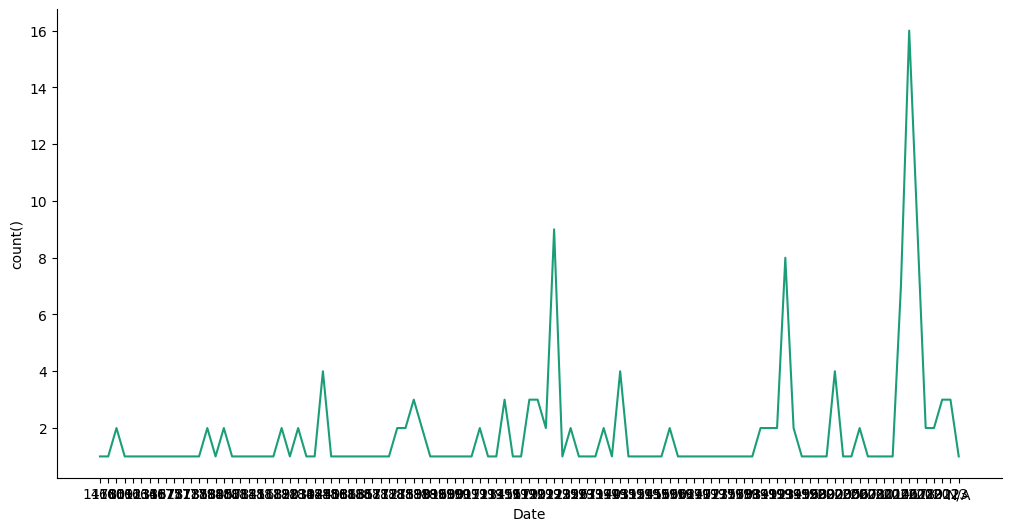

In [ ]:
# title date vs count()
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

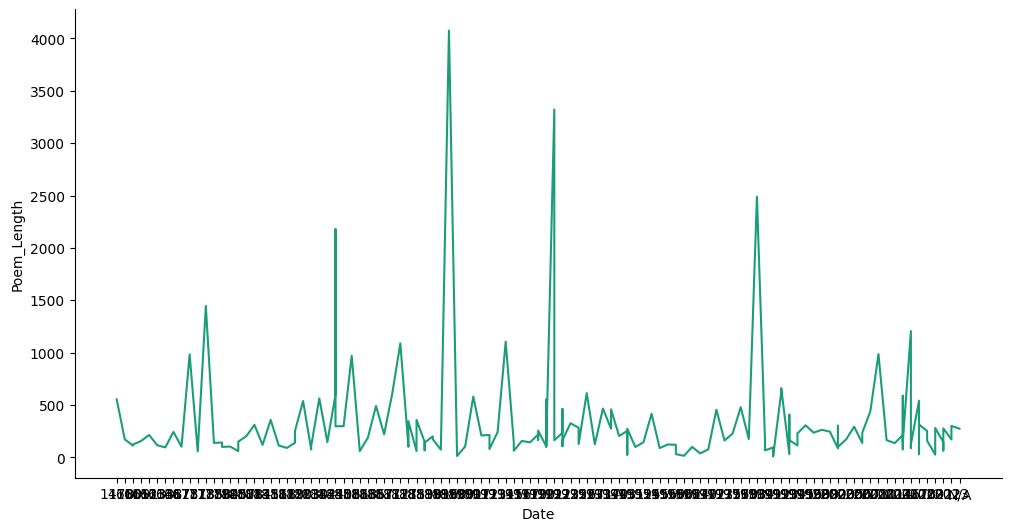

In [ ]:
# title Date vs Poem_Length

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Poem_Length']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Poem_Length')

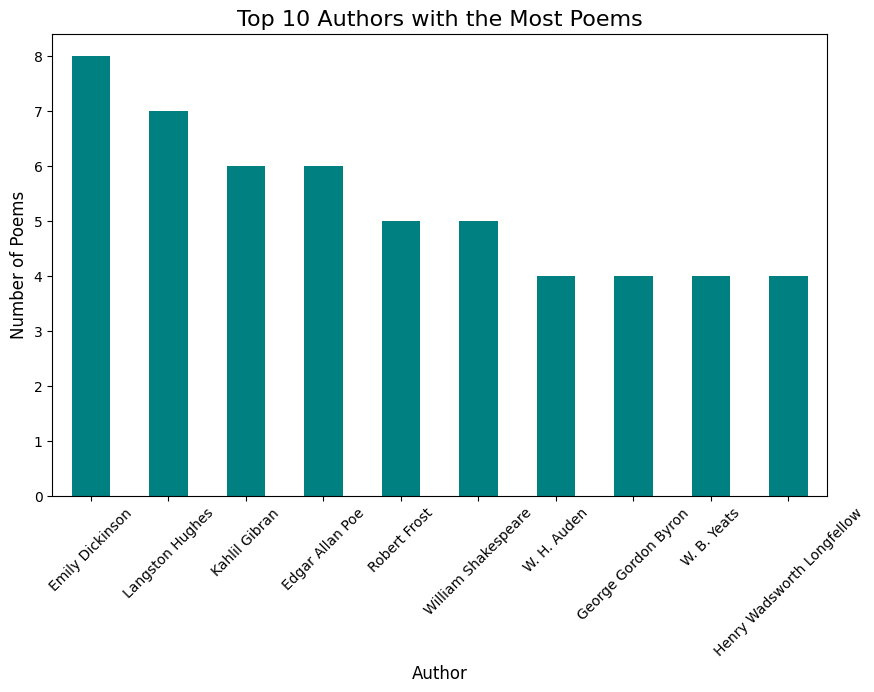

In [ ]:
# Count the number of poems per author
author_counts = df["Author"].value_counts()

# Plot the top 10 authors with the most poems
plt.figure(figsize=(10, 6))
author_counts.head(10).plot(kind="bar", color="teal")
plt.title("Top 10 Authors with the Most Poems", fontsize=16)
plt.xlabel("Author", fontsize=12)
plt.ylabel("Number of Poems", fontsize=12)
plt.xticks(rotation=45)
plt.show()


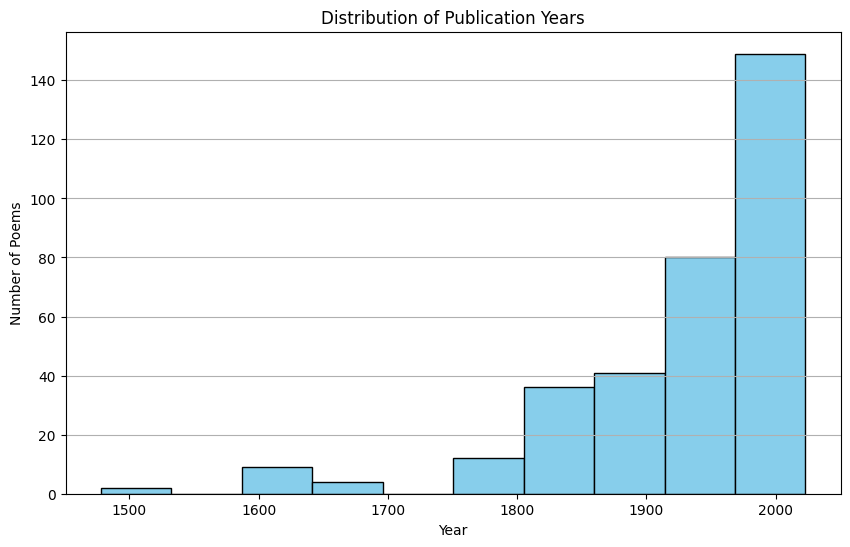

In [ ]:
# distribution of publication years
plt.figure(figsize=(10, 6))
flattened_data['Date'] = pd.to_numeric(flattened_data['Date'], errors='coerce')  # Convert to numeric for sorting
flattened_data['Date'].dropna().astype(int).plot(kind='hist', bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Publication Years')
plt.xlabel('Year')
plt.ylabel('Number of Poems')
plt.grid(axis='y')
plt.show()

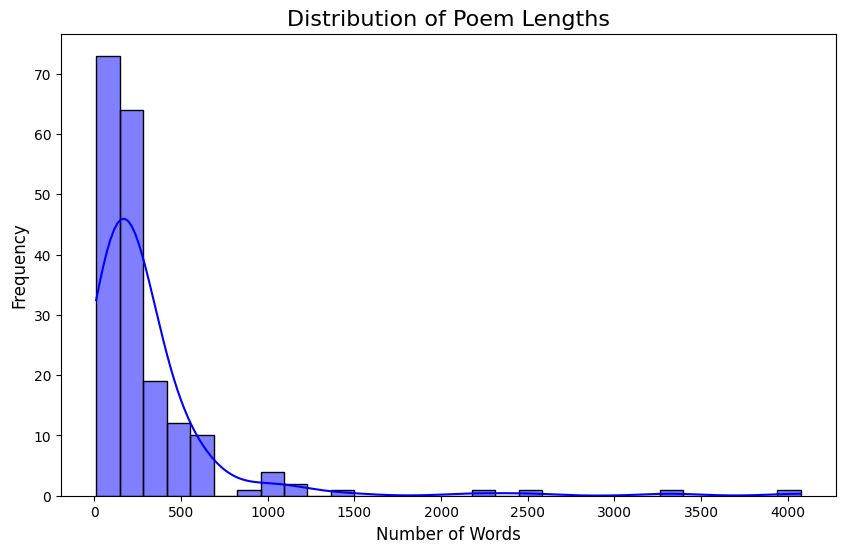

In [ ]:
# Distribution of poem lengths
plt.figure(figsize=(10, 6))
sns.histplot(df["Poem_Length"], bins=30, kde=True, color="blue")
plt.title("Distribution of Poem Lengths", fontsize=16)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


In [ ]:
# Analyze poem lengths (words and lines)
# Convert flattened_data to a DataFrame if it's not already
import pandas as pd
flattened_data = pd.DataFrame(flattened_data) # convert flattened_data to a DataFrame if it's a list

flattened_data['Word Count'] = flattened_data['Poem'].apply(lambda x: len(str(x).split()))
flattened_data['Line Count'] = flattened_data['Poem'].apply(lambda x: len(str(x).splitlines()))

print("\n5. Average poem length (words):", flattened_data['Word Count'].mean())
print("6. Average poem length (lines):", flattened_data['Line Count'].mean())


5. Average poem length (words): 307.5842105263158
6. Average poem length (lines): 43.6578947368421


In [ ]:
# Display the first few rows
print("Sample Data:")
print(flattened_data.head())
# Display the poems with the longest and shortest word counts
longest_poem = flattened_data.loc[flattened_data['Word Count'].idxmax()]
shortest_poem = flattened_data.loc[flattened_data['Word Count'].idxmin()]

print("\n7. Longest Poem:")
print(longest_poem[['Title', 'Author', 'Word Count']])

print("\n8. Shortest Poem:")
print(shortest_poem[['Title', 'Author', 'Word Count']])

Sample Data:
                         Title                 Author  Date  \
0            A Line-storm Song           Robert Frost  1913   
1              The Weary Blues        Langston Hughes  1926   
2  Morning in the Burned House        Margaret Atwood  1995   
3                    On Living           Nâzim Hikmet  1994   
4     I Could Be a Whale Shark  Aimee Nezhukumatathil  2018   

                                                Poem  Poem_Length  Word Count  \
0  The line-storm clouds fly tattered and swift,\...          215         215   
1  Droning a drowsy syncopated tune,\nRocking bac...          284         284   
2  In the burned house I am eating breakfast.\nYo...          229         229   
3  Living is no laughing matter:\n\tyou must live...          408         408   
4  From Oceanic (Copper Canyon Press, 2018). Copy...           31          31   

   Line Count  
0          32  
1          36  
2          36  
3          60  
4           1  

7. Longest Poem:
Title  

In [ ]:
# Save the processed DataFrame as a CSV file
df.to_csv("processed_poems.csv", index=False)
from google.colab import files
files.download("processed_poems.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Preparing for the Transformer


In [ ]:
#We have used the Gutenberg-Poetry dataset, we had our own dataset but that was not giving us adequate results
#We will share our cleaned dataset through Whatsapp or the submission form if possible, we scraped over 250 pages of poems from the 750 we found
#but that seemed inadequate and not diverse enough so we decided to use this pre-existing dataset we found online

In [ ]:
#Hello This is me from the future, the gutenberg dataset was pure horror,
#The results were even worse as compared to our dataset
#So we switched to try the Kaggle dataset, hope it sticks!

In [ ]:
#Me from the future future here, It worked somehow!

In [ ]:
pip install transformers datasets

In [ ]:
#Download the zipped dataset from kaggle before next cell
#"https://www.kaggle.com/datasets/johnhallman/complete-poetryfoundationorg-dataset"

In [ ]:
from google.colab import files
uploaded = files.upload()

import zipfile
import os

zip_file_name = list(uploaded.keys())[0]

# Unzip the file
with zipfile.ZipFile(zip_file_name, "r") as zip_ref:
    zip_ref.extractall("extracted_data")

print("File extracted successfully!")


import pandas as pd

extracted_folder = "extracted_data"
csv_file = None
for file in os.listdir(extracted_folder):
    if file.endswith(".csv"):
        csv_file = os.path.join(extracted_folder, file)
        break

if csv_file:
    print(f"Found CSV file: {csv_file}")
else:
    raise FileNotFoundError("No CSV file found in the extracted folder.")

df = pd.read_csv(csv_file)

print("First few rows of the dataset:")
print(df.head())

# Extract the poems
poems = df["Content"].dropna().tolist()

# Save the processed data to a file
with open("poetry_data.txt", "w", encoding="utf-8") as f:
    f.write("\n\n".join(poems))

print(f"Processed {len(poems)} poems.")

IndexError: list index out of range

In [ ]:
import torch
import os
os.environ["HF_HUB_DISABLE_IMPLICIT_TOKEN"] = "1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained("gpt2")
model = model.to(device)

In [ ]:
from transformers import GPT2Tokenizer

# Load tokenizer and add special tokens
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
special_tokens = {"additional_special_tokens": ["[POEM_START]", "[POEM_END]"]}
tokenizer.add_special_tokens(special_tokens)

# Load GPT-2 and resize embeddings
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

# Move the model to the appropriate device (GPU if available, otherwise CPU)
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Tokenizer and model ready!")
print(f"Using device: {device}")

Tokenizer and model ready!
Using device: cpu


#Enabling gpu if not done yet

In [ ]:
import torch
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

GPU available: False
GPU name: None


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer and add special tokens
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
special_tokens = {"additional_special_tokens": ["[POEM_START]", "[POEM_END]"]}
tokenizer.add_special_tokens(special_tokens)

# Load GPT-2 and resize embeddings
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

# Move the model to the appropriate device (GPU if available, otherwise CPU)
model = model.to(device)

print("Tokenizer and model ready!")

Using device: cpu
Tokenizer and model ready!


In [ ]:
print(f"Model is on: {next(model.parameters()).device}")

Model is on: cpu


In [ ]:
#If not done yet try troubleshooting :/
#I reached the colab limit because of the previous dataset :(

#Continued

In [ ]:
from torch.utils.data import DataLoader
from transformers import TextDataset, DataCollatorForLanguageModeling, GPT2Tokenizer

# Load the preprocessed dataset file (poetry_data.txt)
def load_dataset(file_path, tokenizer, block_size=128):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )

# Initialize tokenizer and dataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
train_dataset = load_dataset("poetry_data.txt", tokenizer)

# Data collator (prepares the dataset to be fed into the model)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Causal language modeling
)

# Create DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=data_collator
)

print("train_dataloader is ready!")

train_dataloader is ready!


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
total_training_steps = len(train_dataloader) * 6

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=total_training_steps
)

print("Optimizer and Scheduler are ready!")

Optimizer and Scheduler are ready!


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_dataset, eval_dataset = train_test_split(train_dataset, test_size=0.2)  # 20% for validation

training_args = TrainingArguments(
    output_dir="./gpt2-poetry",
    overwrite_output_dir=True,
    num_train_epochs=6,
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=3,
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=3e-5,
    warmup_steps=300,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",  # Disable W&B logging
)

# Create Trainer instance and include 'eval_dataset'
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Pass the evaluation dataset here
)

# Train the model
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
import time
import datetime
import torch

# Time formatting function
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

# Training loop with sampling
total_t0 = time.time()
training_stats = []
model = model.to(device)

# Set the pad_token_id properly
model.config.pad_token_id = tokenizer.pad_token_id

for epoch_i in range(6):
    print(f'Beginning epoch {epoch_i+1} of 6')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_labels = batch['input_ids'].to(device)
        b_masks = batch.get('attention_mask', torch.ones_like(b_input_ids)).to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks)
        loss = outputs.loss
        total_train_loss += loss.item()

        if step != 0 and step % 100 == 0:
            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss: {loss.item()}. Time: {elapsed}')

            model.eval()

            sample_outputs = model.generate(
                bos_token_id=tokenizer.bos_token_id,
                do_sample=True,
                top_k=50,
                max_length=200,
                top_p=0.95,
                num_return_sequences=3
            )

            for i, sample_output in enumerate(sample_outputs):
                print(f'Example output {i + 1}: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            print()

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

# After training, generate new poems
model.eval()

# Define the prompt
prompt = "[POEM_START] The moonlight shines so bright"

# Encode the prompt and move to device
generated = torch.tensor(tokenizer.encode(prompt, add_special_tokens=True)).unsqueeze(0).to(device)

# Generate text with the specified parameters
sample_outputs = model.generate(
    generated,
    bos_token_id=tokenizer.bos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    num_return_sequences=3,
    temperature=1.0,
    repetition_penalty=1.2,
    no_repeat_ngram_size=2,
    early_stopping=True
)

# Print out the generated samples
for i, sample_output in enumerate(sample_outputs):
    print(f"{i + 1}: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n\n")

In [ ]:
# After training, generate new poems
model.eval()

# Define the prompt
prompt = "[POEM_START] The moonlight shines so bright"

# Encode the prompt and move to device
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)

# Generate text with adjusted parameters
sample_outputs = model.generate(
    generated,
    do_sample=True,
    top_k=40,                    # Reduce the top-k to limit token choices
    max_length=200,              # Desired output length for generated text
    top_p=0.85,                  # Lower top-p to make the output more focused
    num_return_sequences=3,      # Generate 3 sequences for diversity
    temperature=0.7,             # Lower temperature for less randomness
    repetition_penalty=1.5,      # Increased repetition penalty to avoid repeating n-grams
    no_repeat_ngram_size=2,      # Prevent repetition of n-grams
    early_stopping=True,         # Stop generation when EOS token is reached
    pad_token_id=tokenizer.eos_token_id  # Set pad_token_id to eos_token_id for GPT-2
)

# Print out the generated samples and clean them
for i, sample_output in enumerate(sample_outputs):
    decoded_text = tokenizer.decode(sample_output, skip_special_tokens=True)
    # Clean up unwanted symbols or HTML-like tags
    cleaned_text = decoded_text.replace("<", "").replace(">", "").replace("&", "").replace(";", "")
    cleaned_text = ' '.join(cleaned_text.split())  # Remove extra spaces and clean up
    print(f"{i + 1}: {cleaned_text}\n\n")

1: [POEM_START] The moonlight shines so bright that no one can see it. /a/li lg-3 mb 3" ul class="list" !-- '` --h2 id=customerIdquot:adapterName, autocomplete method='get' aria--hasFocus:'+null"/hmRpcID" data–analyticsActions="/about/accounts/" /data%5Bsupport!originatingSoftwareAccelerationFundingForm%}#userManagement /div) {{{action="" typeof "application/*cssopts__modules.*}" role = "_loginDialogBoxModalNavigationButton jsxMLInputControlTextContentMutedSolutions Button flexSuggestionsLandedOffsetWidth mtUIddoCopilotMenuDismiss dmVectoringReloadedList pngOverlayWrapSlider h4d8p


2: [POEM_START] The moonlight shines so bright you can see all the stars!" /a/li /uldiv class="d-flex flex--column" span dataclass="" position=relative" id="/articles/industry#1948221814"/spacer" typeof content="#4e0ae94b3f8"svg ariaUrl='https://www.twitchassetscenter2cdn1n5jr6hxl9qEJKzTkHXu+yMVv7pZmPwSigUiIoQcAACFgoOddLWGYDtCALsRUFgzNhoBkbKBggAAANRAGBAMBAADHAEGEBAbAYBIABIDDAAdEAASAEIGAFIBAKHDAAAABBECBDGFBC

In [ ]:
import os

output_dir = "/content/drive/My Drive/gpt2-poetry"
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f'Model and tokenizer saved to {output_dir}')

# Kaggle Code


In [ ]:
#As I couldn't train the dataset in colab as i had exhausted my gpu units :/ I decided to use kaggle
#Here is the code I used in kaggle to get the generated poems
#Its the same code as above just configured for kaggle(thanks to gpt4 for building gpt2 here)
#Also I reduced the epochs and no of examples to train on to reduce training time or
#If we choose not to do so we can expect better results with the trade of time

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
johnhallman_complete_poetryfoundationorg_dataset_path = kagglehub.dataset_download('johnhallman/complete-poetryfoundationorg-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/complete-poetryfoundationorg-dataset/kaggle_poem_dataset.csv


In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

GPU is available: Tesla T4


In [ ]:
# Cell 1: Install Dependencies
!pip install transformers datasets

# Cell 2: Load Dataset in Kaggle
import pandas as pd

# Load the dataset from Kaggle's input directory
dataset_path = "/kaggle/input/complete-poetryfoundationorg-dataset/kaggle_poem_dataset.csv"  # Update with your dataset path
df = pd.read_csv(dataset_path)

# Inspect the dataset
print("First few rows of the dataset:")
print(df.head())

# Extract the poems (use the correct column name, which is "Content")
poems = df["Content"].dropna().tolist()  # Extract the "Content" column and remove missing values

# Reduce the number of poems to speed up training (e.g., take the first 5000 poems)
poems = poems[:5000]

# Save the processed data to a file
with open("poetry_data.txt", "w", encoding="utf-8") as f:
    f.write("\n\n".join(poems))  # Save poems, separated by double newlines

print(f"Processed {len(poems)} poems.")

# Cell 3: Load Dataset Using 🤗 Datasets
from datasets import load_dataset

# Load the dataset from the text file
dataset = load_dataset("text", data_files="poetry_data.txt")

# Cell 4: Set Up Device and Model
import torch
import os
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Set the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add a custom pad token and set it
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = '[PAD]'

# Add custom special tokens for poem start and end
special_tokens = {"additional_special_tokens": ["[POEM_START]", "[POEM_END]"]}
tokenizer.add_special_tokens(special_tokens)

# Load GPT-2 and resize embeddings
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

# Move the model to the appropriate device (GPU if available, otherwise CPU)
model = model.to(device)

print("Tokenizer and model are ready!")
print(f"Using device: {device}")

# Cell 5: Tokenize Dataset
def tokenize_function(examples):
    # Tokenizing and adding labels (for language modeling, labels are the same as input_ids)
    encoding = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)
    encoding["labels"] = encoding["input_ids"]  # Use input_ids as labels for GPT-2 language modeling
    return encoding

# Map the function to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Reduce the size of the training and validation datasets to speed up training
tokenized_dataset = tokenized_dataset["train"].select(range(5000))  # Only use the first 5000 examples for training

# Split the dataset into training and validation sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

print("Dataset loaded and tokenized!")

# Cell 6: Data Collator and DataLoader
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling

# Set up the data collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # GPT-2 uses causal language modeling, not masked language modeling
)

# Create DataLoader for the training dataset
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,  # Adjust batch size based on your available resources
    shuffle=True,
    collate_fn=data_collator
)

# Create DataLoader for the validation dataset
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=4,  # Same batch size for validation
    shuffle=False,
    collate_fn=data_collator
)

# Cell 7: Set Up Optimizer and Scheduler
from torch.optim import AdamW  # Use PyTorch's AdamW implementation

# Set up optimizer (using AdamW from PyTorch)
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
total_training_steps = len(train_dataloader) * 3  # Reduced to 3 epochs for faster training

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,  # Adjust based on your needs
    num_training_steps=total_training_steps
)

print("Optimizer and Scheduler are ready!")

# Cell 8: Training Configuration and Trainer
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-poetry",
    overwrite_output_dir=True,
    num_train_epochs=3,  # Reduced epochs to 3
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=3,
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=3e-5,
    warmup_steps=300,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",  # Disable W&B logging
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Use evaluation dataset
    data_collator=data_collator,  # Use the correct data collator
)

# Train the model
trainer.train()



First few rows of the dataset:
   Unnamed: 0             Author           Title  Poetry Foundation ID  \
0           0     Wendy Videlock               !                 55489   
1           1  Hailey Leithauser               0                 41729   
2           2      Jody Gladding      1-800-FEAR                 57135   
3           3     Joseph Brodsky  1 January 1965                 56736   
4           4       Ted Berrigan         3 Pages                 51624   

                                             Content  
0  Dear Writers, I’m compiling the first in what ...  
1  Philosophic\nin its complex, ovoid emptiness,\...  
2  We'd  like  to  talk  with  you  about  fear t...  
3  The Wise Men will unlearn your name.\nAbove yo...  
4  For Jack Collom\n10 Things I do Every Day\n\np...  
Processed 5000 poems.


Generating train split: 0 examples [00:00, ? examples/s]

Using device: cuda
Tokenizer and model are ready!
Using device: cuda


Map:   0%|          | 0/236551 [00:00<?, ? examples/s]

Dataset loaded and tokenized!
Optimizer and Scheduler are ready!


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss
500,5.231800,5.069644
1000,4.809100,5.081061
1500,4.407900,5.132472


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=1500, training_loss=4.874259195963542, metrics={'train_runtime': 462.2286, 'train_samples_per_second': 25.961, 'train_steps_per_second': 3.245, 'total_flos': 783876096000000.0, 'train_loss': 4.874259195963542, 'epoch': 3.0})

In [ ]:
#*********please read below**********

There is a clear case of overfitting here, i couldnt pinpoint the exact cause as the number of epochs and training examples were deliberately kept low, I read a related paper online(https://creativecoding.soe.ucsc.edu/courses/cmpm202_w20/_schedule/TransformerBard_202.pdf), It could be due to temprature values, but cant say anything for sure

In [ ]:
# After training, generate new poems
model.eval()  # Switch to evaluation mode

# Define the prompt
prompt = "[POEM_START] The moonlight shines so bright"

# Encode the prompt and move to device
generated = torch.tensor(tokenizer.encode(prompt, add_special_tokens=True)).unsqueeze(0).to(device)

# Generate text with the specified parameters
sample_outputs = model.generate(
    generated,
    bos_token_id=tokenizer.bos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    num_return_sequences=3,
    temperature=1.0,
    repetition_penalty=1.2,
    no_repeat_ngram_size=2,
    early_stopping=True
)

# Print out the generated samples
for i, sample_output in enumerate(sample_outputs):
    print(f"{i + 1}: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n\n")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


1:  The moonlight shines so bright, the dark is broken by a cry to silence. We hear our voices at random; we know who's right! And then something ends—you look around and watch for anything you can find: black or white photographs of men with their guns pointed toward each other in public places? They're probably going along there now because they'll leave us alone if it meant turning out into another shot video that has nothing else but bad music on them (they'd always had one before)—but what do I have here except my phone numbers? What does this mean when everything went wrong?"
I am dead broke — no big deal today...no good deed done ! Why could anyone be worse off  to me than some guy next door without getting arrested while hanging itself like his grandmother’s snow-white beard . Where was he made up all night ? No chance anywhere though not ever again : how come people still live once someone knows about crime rates from high


2:  The moonlight shines so bright through the darkn

In [ ]:
import os

# Step 1: Save the model locally in Kaggle
output_dir = "./gpt2-poetry"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the trained model, configuration, and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f'Model and tokenizer saved locally to {output_dir}')

# Step 2: Create a zip file for downloading
import shutil
shutil.make_archive("gpt2-poetry", 'zip', output_dir)

print("Model and tokenizer zipped as 'gpt2-poetry.zip'. You can now download it.")

# Step 3: Download the file in Kaggle interface
from IPython.display import FileLink
FileLink("gpt2-poetry.zip")


Model and tokenizer saved locally to ./gpt2-poetry
Model and tokenizer zipped as 'gpt2-poetry.zip'. You can now download it.


/kaggle/working/gpt2-poetry.zip